In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statistics
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import naive_bayes
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from pydot import graph_from_dot_data
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read in CSV file
data = pd.read_csv("data.csv").dropna()
data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,6,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,4860406,2011,10,6,16,2,1,04,01,1,...,01,01,2003,01,M,24,11,1,02,1
1,4860407,2011,10,6,16,2,1,04,01,1,...,01,01,2003,02,M,09,31,2,02,2
2,4860408,2011,10,6,16,2,1,04,01,1,...,01,01,2003,03,F,07,22,2,02,2
3,4860409,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,01,M,50,11,1,02,1
4,4860410,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,02,M,15,13,1,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5860401,2014,UU,U,UU,2,UU,UU,01,U,...,13,07,UUUU,01,M,24,11,1,NN,1
999996,5860402,2014,UU,U,23,2,01,06,05,1,...,1,14,2006,01,M,29,96,2,09,5
999997,5860403,2014,UU,U,14,2,01,02,01,1,...,1,01,2006,01,F,UU,11,2,01,1
999998,5860404,2014,UU,U,22,1,01,06,01,2,...,1,22,UUUU,01,M,67,12,3,01,U


# Data Cleaning and Dimensionality Reduction (Binning)

In [3]:
# Data cleaning: P_ISEV
data = data[data['P_ISEV'] != "N"]
data = data[data['P_ISEV'] != "U"]
data = data[data['P_ISEV'] != "X"]
data['P_ISEV'] = pd.to_numeric(data.P_ISEV)
data.loc[(data.P_ISEV == 1),'P_ISEV'] = 0
data.loc[(data.P_ISEV == 2),'P_ISEV'] = 1
data.loc[(data.P_ISEV == 3),'P_ISEV'] = 1
data['P_ISEV'] = pd.Categorical(data.P_ISEV)
data['P_ISEV'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [4]:
# Data cleaning: C_YEAR
data.C_YEAR = pd.Categorical(pd.to_numeric(data.C_YEAR))
data['C_YEAR'].unique()

[2011, 2012, 2013, 2014]
Categories (4, int64): [2011, 2012, 2013, 2014]

In [5]:
# Data cleaning: C_MNTH
data = data[data['C_MNTH'] != "UU"]
data = data[data['C_MNTH'] != "XX"]
data.C_MNTH = pd.Categorical(pd.to_numeric(data.C_MNTH))
data['C_MNTH'].unique()

[10, 11, 12, 1, 2, ..., 5, 6, 7, 8, 9]
Length: 12
Categories (12, int64): [10, 11, 12, 1, ..., 6, 7, 8, 9]

In [6]:
# Data cleaning: C_WDAY
data = data[data['C_WDAY'] != "U"] 
data = data[data['C_WDAY'] != "X"] 
data.C_WDAY = pd.Categorical(pd.to_numeric(data.C_WDAY))
data['C_WDAY'].unique()

[6, 7, 1, 2, 3, 4, 5]
Categories (7, int64): [6, 7, 1, 2, 3, 4, 5]

In [7]:
# Data cleaning: C_HOUR
data = data[data['C_HOUR'] != "UU"]
data = data[data['C_HOUR'] != "XX"]
# Make colliosn hour group categories
data['C_HOUR'] = pd.to_numeric(data['C_HOUR'])
data['C_HOUR'] = pd.cut(data['C_HOUR'], bins=[0,3,6,9,12,15,18,21,23,float('inf')], right=False)
data['C_HOUR'].unique()

[[15.0, 18.0), [12.0, 15.0), [18.0, 21.0), [9.0, 12.0), [3.0, 6.0), [0.0, 3.0), [6.0, 9.0), [21.0, 23.0), [23.0, inf)]
Categories (9, interval[float64]): [[0.0, 3.0) < [3.0, 6.0) < [6.0, 9.0) < [9.0, 12.0) ... [15.0, 18.0) < [18.0, 21.0) < [21.0, 23.0) < [23.0, inf)]

In [8]:
# Data cleaning: C_VEHS
data = data[data['C_VEHS'] != "UU"]
data = data[data['C_VEHS'] != "XX"]
# Make vehicle collided group categories rather than usuing indidvidual number of cars in collision
data['C_VEHS'] = pd.to_numeric(data['C_VEHS'])
data['C_VEHS'] = pd.cut(data['C_VEHS'], bins=[1,5,26,float('inf')], right=False)
data['C_VEHS'].unique()

[[1.0, 5.0), [5.0, 26.0), [26.0, inf)]
Categories (3, interval[float64]): [[1.0, 5.0) < [5.0, 26.0) < [26.0, inf)]

In [9]:
# Data cleaning: C_CONF
data = data[data['C_CONF'] != "QQ"]
data = data[data['C_CONF'] != "UU"]
data = data[data['C_CONF'] != "XX"]
data['C_CONF'] = pd.to_numeric(data['C_CONF'])
data['C_CONF'] = pd.cut(data['C_CONF'], bins=[1,21,31,float('inf')], right=False)
data['C_CONF'].unique()

[[1.0, 21.0), [31.0, inf), [21.0, 31.0)]
Categories (3, interval[float64]): [[1.0, 21.0) < [21.0, 31.0) < [31.0, inf)]

In [10]:
# Data cleaning: C_RCFG
data = data[data['C_RCFG'] != "QQ"]
data = data[data['C_RCFG'] != "UU"] 
data = data[data['C_RCFG'] != "XX"]
data.C_RCFG = pd.Categorical(pd.to_numeric(data.C_RCFG))
data['C_RCFG'].unique()

[1, 2, 4, 3, 5, 8, 6, 9, 7, 10]
Categories (10, int64): [1, 2, 4, 3, ..., 6, 9, 7, 10]

In [11]:
# Data cleaning: C_WTHR
data = data[data['C_WTHR'] !=  "Q"]
data = data[data['C_WTHR'] !=  "U"]
data = data[data['C_WTHR'] !=  "X"]
data.C_WTHR = pd.Categorical(pd.to_numeric(data.C_WTHR))
data['C_WTHR'].unique()

[1, 3, 4, 2, 7, 6, 5]
Categories (7, int64): [1, 3, 4, 2, 7, 6, 5]

In [12]:
# Data cleaning: C_RSUR
data = data[data['C_RSUR'] !=  "Q"]
data = data[data['C_RSUR'] !=  "U"]
data = data[data['C_RSUR'] !=  "X"]
data.C_RSUR = pd.Categorical(pd.to_numeric(data.C_RSUR))
data['C_RSUR'].unique()

[1, 2, 5, 3, 9, 6, 8, 4, 7]
Categories (9, int64): [1, 2, 5, 3, ..., 6, 8, 4, 7]

In [13]:
# Data cleaning: C_RALN 
data = data[data['C_RALN'] != "Q"] 
data = data[data['C_RALN'] != "U"] 
data = data[data['C_RALN'] != "X"]
data.C_RALN = pd.Categorical(pd.to_numeric(data.C_RALN))
data['C_RALN'].unique()

[1, 4, 3, 5, 2, 6]
Categories (6, int64): [1, 4, 3, 5, 2, 6]

In [14]:
# Data cleaning: C_TRAF 
data = data[data['C_TRAF'] != "QQ"]
data = data[data['C_TRAF'] != "UU"]
data = data[data['C_TRAF'] != "XX"]
data['C_TRAF'] = pd.to_numeric(data['C_TRAF'])
data['C_TRAF'] = pd.cut(data['C_TRAF'], bins=[1,3,8,10,13,15,17,18,float('inf')], right=False)
data['C_TRAF'].unique()

[[18.0, inf), [3.0, 8.0), [1.0, 3.0), [10.0, 13.0), [13.0, 15.0), [8.0, 10.0), [15.0, 17.0), [17.0, 18.0)]
Categories (8, interval[float64]): [[1.0, 3.0) < [3.0, 8.0) < [8.0, 10.0) < [10.0, 13.0) < [13.0, 15.0) < [15.0, 17.0) < [17.0, 18.0) < [18.0, inf)]

In [15]:
# Data cleaning: V_TYPE
data = data[data['V_TYPE'] != "QQ"] 
data = data[data['V_TYPE'] != "UU"] 
data = data[data['V_TYPE'] != "NN"] 
data['V_TYPE'] = pd.to_numeric(data['V_TYPE'])
data['V_TYPE'] = pd.cut(data['V_TYPE'], bins=[0,5,8,9,float('inf')], right=False)
data['V_TYPE'].unique()

[[0.0, 5.0), [9.0, inf), [8.0, 9.0), [5.0, 8.0)]
Categories (4, interval[float64]): [[0.0, 5.0) < [5.0, 8.0) < [8.0, 9.0) < [9.0, inf)]

In [16]:
# Data cleaning: V_YEAR
data = data[data['V_YEAR'] != "NNNN"] 
data = data[data['V_YEAR'] != "UUUU"] 
data = data[data['V_YEAR'] != "QQQQ"]
# Make vehicle year group categories rather than using indidvidual years
data['V_YEAR'] = pd.to_numeric(data['V_YEAR'])
data['V_YEAR'] = pd.cut(data['V_YEAR'], bins=[1900,1950,1980,1990,2000,2010,float('inf')], right=False)
data['V_YEAR'].unique()

[[2000.0, 2010.0), [2010.0, inf), [1990.0, 2000.0), [1980.0, 1990.0), [1950.0, 1980.0), [1900.0, 1950.0)]
Categories (6, interval[float64]): [[1900.0, 1950.0) < [1950.0, 1980.0) < [1980.0, 1990.0) < [1990.0, 2000.0) < [2000.0, 2010.0) < [2010.0, inf)]

In [17]:
# Data cleaning: P_SEX
data = data[data['P_SEX'] != "N"]
data = data[data['P_SEX'] != "U"] 
data.P_SEX = pd.Categorical(data.P_SEX)
data['P_SEX'].unique()

[M, F]
Categories (2, object): [M, F]

In [18]:
# Data cleaning: P_AGE
data = data[data['P_AGE'] != "NN"]
data = data[data['P_AGE'] != "UU"]
data = data[data['P_AGE'] != "XX"]
# Make age-group categories rather than usuing indidvidual ages
data['P_AGE'] = pd.to_numeric(data['P_AGE'])
data['P_AGE'] = pd.cut(data['P_AGE'], bins=[0,10,20,30,40,50,60,70,80,90,float('inf')], right=False)
data['P_AGE'].unique()  

[[20.0, 30.0), [0.0, 10.0), [60.0, 70.0), [40.0, 50.0), [10.0, 20.0), [70.0, 80.0), [80.0, 90.0), [50.0, 60.0), [30.0, 40.0), [90.0, inf)]
Categories (10, interval[float64]): [[0.0, 10.0) < [10.0, 20.0) < [20.0, 30.0) < [30.0, 40.0) ... [60.0, 70.0) < [70.0, 80.0) < [80.0, 90.0) < [90.0, inf)]

In [19]:
# Data cleaning: P_PSN
data = data[data['P_PSN'] != "NN"]
data = data[data['P_PSN'] != "QQ"]
data = data[data['P_PSN'] != "UU"]
data = data[data['P_PSN'] != "XX"]
# Make person position categories
data['P_PSN'] = pd.to_numeric(data['P_PSN'])

# 96 is position unknown so get rid of rows with this
data = data[data['P_PSN'] != 96]
data['P_PSN'] = pd.cut(data['P_PSN'], bins=[11,21,31,34,98,99,float('inf')], right=False)
data['P_PSN'].unique()

[[11.0, 21.0), [31.0, 34.0), [21.0, 31.0), [98.0, 99.0), [34.0, 98.0)]
Categories (5, interval[float64]): [[11.0, 21.0) < [21.0, 31.0) < [31.0, 34.0) < [34.0, 98.0) < [98.0, 99.0)]

In [20]:
# Data cleaning: P_SAFE
data = data[data['P_SAFE'] != "NN"]
data = data[data['P_SAFE'] != "QQ"]
data = data[data['P_SAFE'] != "UU"]
data = data[data['P_SAFE'] != "XX"]
data.P_SAFE = pd.Categorical(pd.to_numeric(data.P_SAFE))
data['P_SAFE'].unique()  

[2, 1, 9, 13, 12, 10, 11]
Categories (7, int64): [2, 1, 9, 13, 12, 10, 11]

In [21]:
# Data cleaning: P_USER
data = data[data['P_USER'] != "U"] 
data.P_USER = pd.Categorical(pd.to_numeric(data.P_USER))
data['P_USER'].unique()  

[1, 2, 5, 4]
Categories (4, int64): [1, 2, 5, 4]

# Data Exploration

In [22]:
data['P_ISEV'].value_counts()

1    314346
0    245002
Name: P_ISEV, dtype: int64

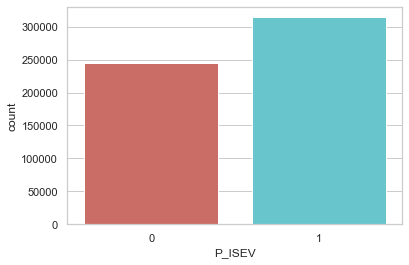

In [23]:
sns.countplot(x='P_ISEV', data=data, palette='hls')
plt.rcParams["figure.figsize"] = [12,5]
plt.show()

In [24]:
data['C_YEAR'].value_counts()

2012    180168
2013    178941
2014    165375
2011     34864
Name: C_YEAR, dtype: int64

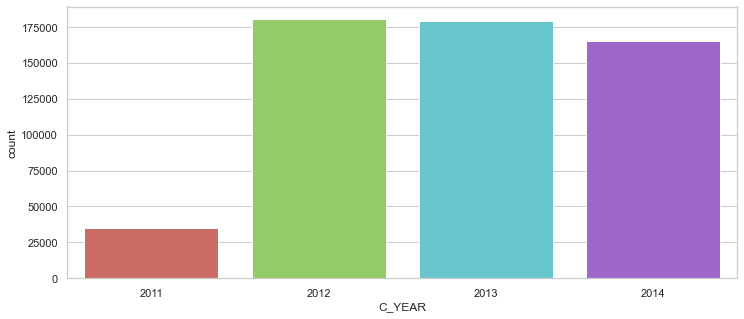

In [25]:
sns.countplot(x='C_YEAR', data=data, palette='hls')
plt.show()

In [26]:
data['C_MNTH'].value_counts()

12    60710
11    60444
10    51061
8     48805
7     48313
9     46792
6     45883
1     45386
5     42674
2     38278
3     36725
4     34277
Name: C_MNTH, dtype: int64

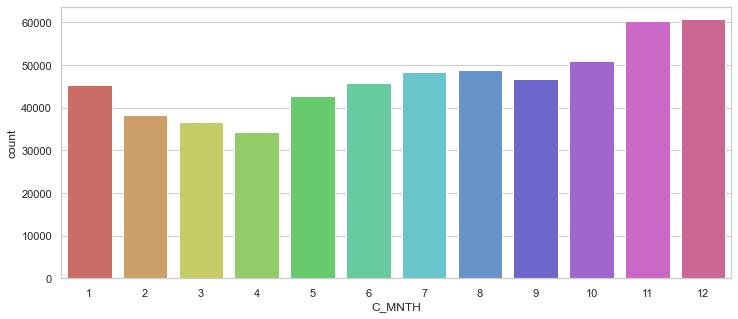

In [27]:
sns.countplot(x='C_MNTH', data=data, palette='hls')
plt.show()

In [28]:
data['C_WDAY'].value_counts()

5    95259
4    85286
6    79738
3    79565
2    79213
1    74237
7    66050
Name: C_WDAY, dtype: int64

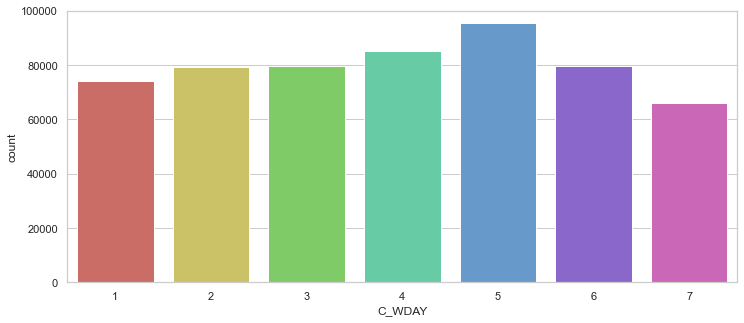

In [29]:
sns.countplot(x='C_WDAY', data=data, palette='hls')
plt.show()

In [30]:
data['C_HOUR'].value_counts()

[15.0, 18.0)    153215
[12.0, 15.0)    110636
[18.0, 21.0)     81906
[9.0, 12.0)      80144
[6.0, 9.0)       64625
[21.0, 23.0)     30359
[0.0, 3.0)       16528
[3.0, 6.0)       12280
[23.0, inf)       9655
Name: C_HOUR, dtype: int64

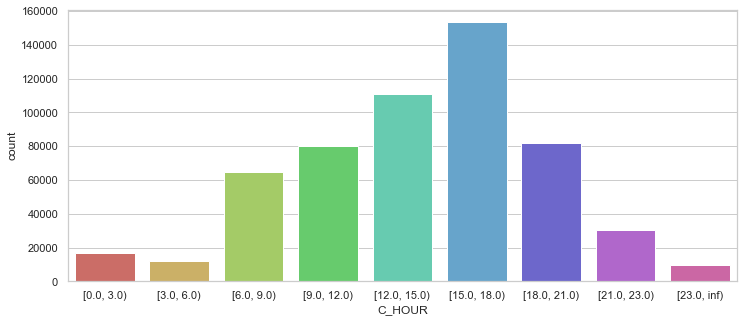

In [31]:
sns.countplot(x='C_HOUR', data=data, palette='hls')
plt.show()

In [32]:
data['C_VEHS'].value_counts()

[1.0, 5.0)     551665
[5.0, 26.0)      7441
[26.0, inf)       242
Name: C_VEHS, dtype: int64

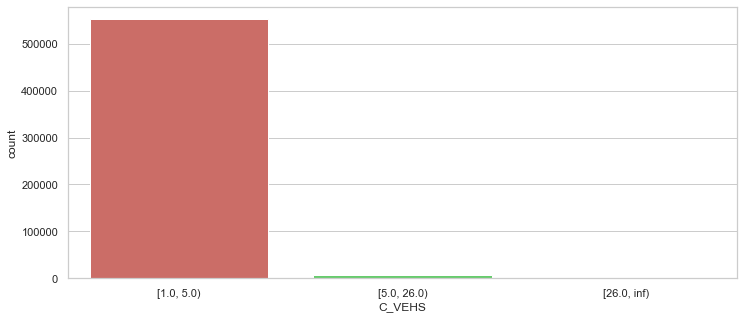

In [33]:
sns.countplot(x='C_VEHS', data=data, palette='hls')
plt.show()

In [34]:
data['C_CONF'].value_counts()

[21.0, 31.0)    234181
[31.0, inf)     222824
[1.0, 21.0)     102343
Name: C_CONF, dtype: int64

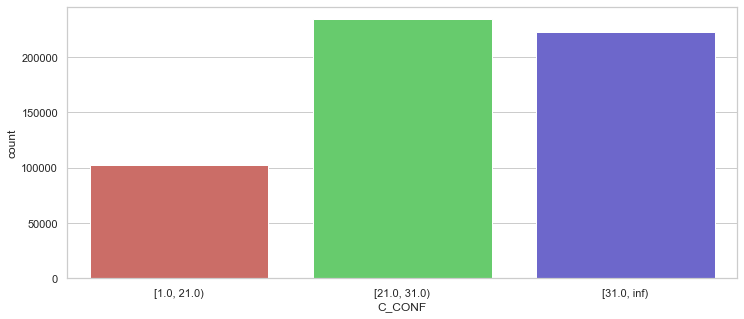

In [35]:
sns.countplot(x='C_CONF', data=data, palette='hls')
plt.show()

In [36]:
data['C_RCFG'].value_counts()

2     290706
1     230455
3      28568
5       5335
4       1527
8       1213
6        855
9        521
10       112
7         56
Name: C_RCFG, dtype: int64

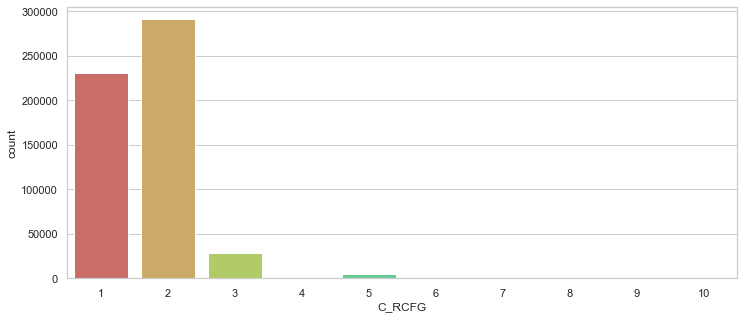

In [37]:
sns.countplot(x='C_RCFG', data=data, palette='hls')
plt.show()

In [38]:
data['C_WTHR'].value_counts()

1    401194
3     58952
2     50777
4     34477
6      9251
5      3007
7      1690
Name: C_WTHR, dtype: int64

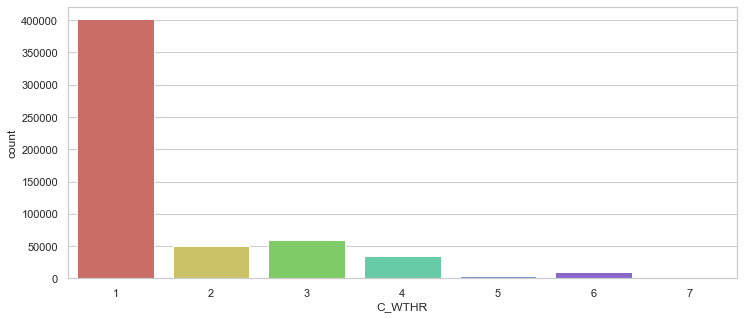

In [39]:
sns.countplot(x='C_WTHR', data=data, palette='hls')
plt.show()

In [40]:
data['C_RSUR'].value_counts()

1    380311
2    107833
5     34748
3     23980
4      9732
6      2196
7       391
8       124
9        33
Name: C_RSUR, dtype: int64

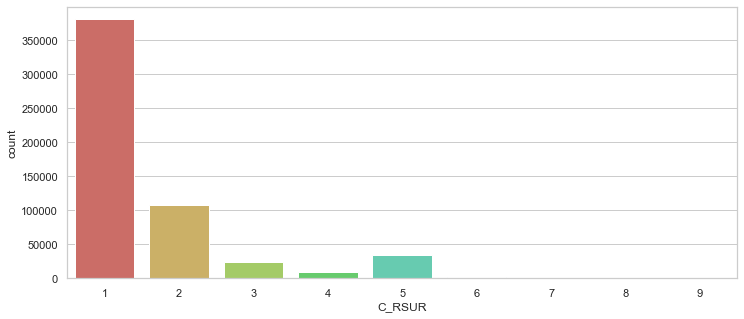

In [41]:
sns.countplot(x='C_RSUR', data=data, palette='hls')
plt.show()

In [42]:
data['C_RALN'].value_counts()

1    442924
2     53847
3     33352
4     18238
5      6189
6      4798
Name: C_RALN, dtype: int64

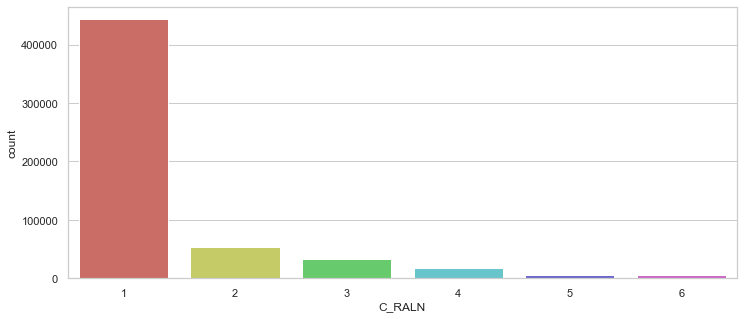

In [43]:
sns.countplot(x='C_RALN', data=data, palette='hls')
plt.show()

In [44]:
data['C_TRAF'].value_counts()

[18.0, inf)     292067
[1.0, 3.0)      184501
[3.0, 8.0)       77582
[8.0, 10.0)       3037
[10.0, 13.0)      1078
[13.0, 15.0)       593
[15.0, 17.0)       423
[17.0, 18.0)        67
Name: C_TRAF, dtype: int64

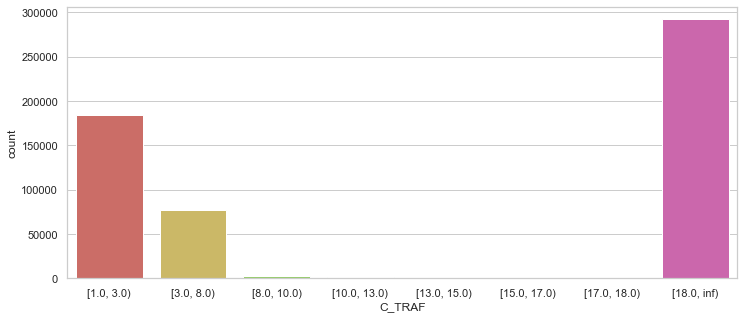

In [45]:
sns.countplot(x='C_TRAF', data=data, palette='hls')
plt.show()

In [46]:
data['V_TYPE'].value_counts()

[0.0, 5.0)    508686
[5.0, 8.0)     24107
[9.0, inf)     20011
[8.0, 9.0)      6544
Name: V_TYPE, dtype: int64

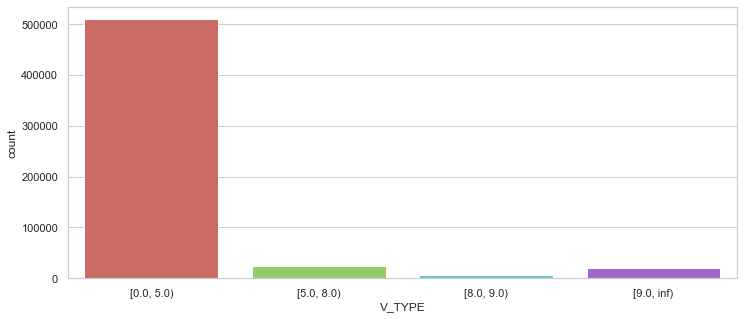

In [47]:
sns.countplot(x='V_TYPE', data=data, palette='hls')
plt.show()

In [48]:
data['V_YEAR'].value_counts()

[2000.0, 2010.0)    351456
[2010.0, inf)       134051
[1990.0, 2000.0)     68597
[1980.0, 1990.0)      4409
[1950.0, 1980.0)       793
[1900.0, 1950.0)        42
Name: V_YEAR, dtype: int64

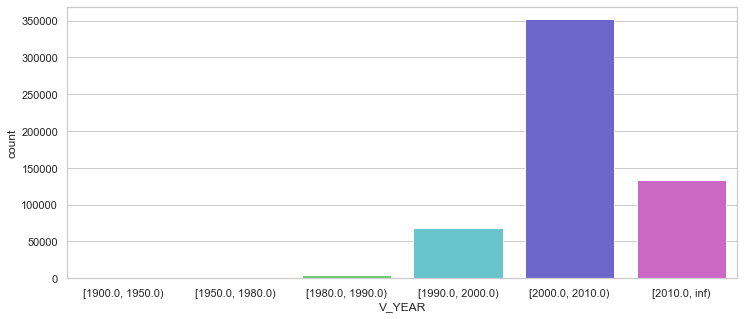

In [49]:
sns.countplot(x='V_YEAR', data=data, palette='hls')
plt.show()

In [50]:
data['P_SEX'].value_counts()

M    294077
F    265271
Name: P_SEX, dtype: int64

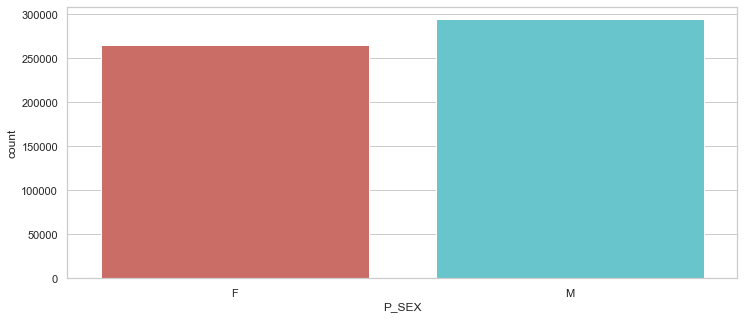

In [51]:
sns.countplot(x='P_SEX', data=data, palette='hls')
plt.show()

In [52]:
data['P_PSN'].value_counts()

[11.0, 21.0)    491971
[21.0, 31.0)     63540
[31.0, 34.0)      3728
[98.0, 99.0)        72
[34.0, 98.0)        37
[99.0, inf)          0
Name: P_PSN, dtype: int64

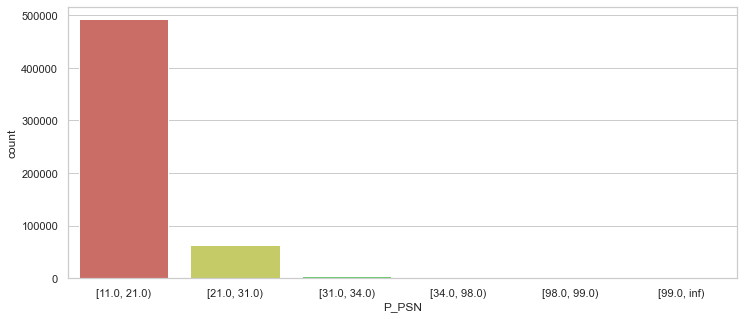

In [53]:
sns.countplot(x='P_PSN', data=data, palette='hls')
plt.show()

In [54]:
data['P_SAFE'].value_counts()

2     527845
9      10416
1      10371
13      6552
12      4162
10         2
11         0
Name: P_SAFE, dtype: int64

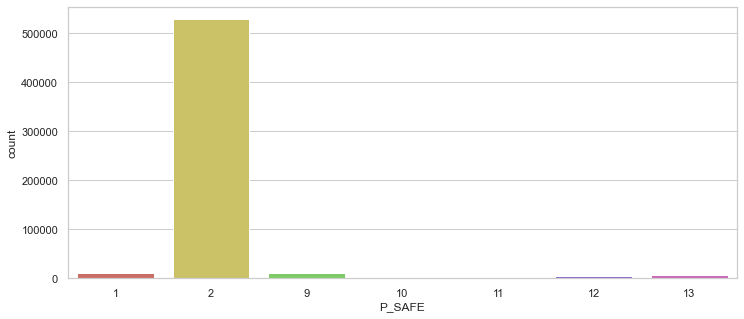

In [55]:
sns.countplot(x='P_SAFE', data=data, palette='hls')
plt.show()

In [56]:
data['P_USER'].value_counts()

1    383086
2    164757
5     10921
4       584
Name: P_USER, dtype: int64

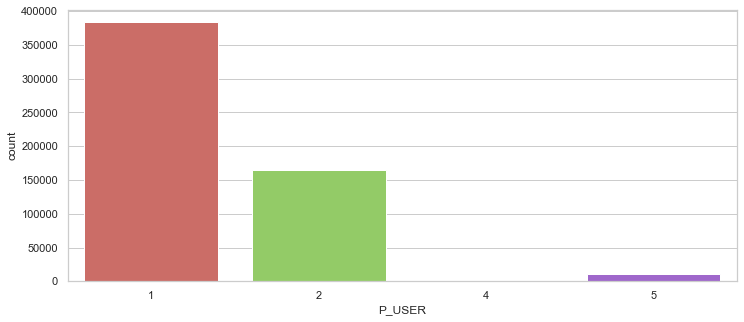

In [57]:
sns.countplot(x='P_USER', data=data, palette='hls')
plt.show()

# Prepare Data for Maching Learning

In [58]:
# Convert data to categorical features (get dummy variables) 
cat_vars=['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF',
         'V_TYPE','V_YEAR','P_SEX','P_AGE','P_PSN','P_SAFE','P_USER']
train = data['P_ISEV']
for var in cat_vars:
    cat_list = pd.get_dummies(data[var], prefix=var, drop_first=True)
    train = pd.concat([train,cat_list],axis=1)

categories = train.drop('P_ISEV',axis=1).columns.values
    
train.columns.values

array(['P_ISEV', 'C_YEAR_2012', 'C_YEAR_2013', 'C_YEAR_2014', 'C_MNTH_2',
       'C_MNTH_3', 'C_MNTH_4', 'C_MNTH_5', 'C_MNTH_6', 'C_MNTH_7',
       'C_MNTH_8', 'C_MNTH_9', 'C_MNTH_10', 'C_MNTH_11', 'C_MNTH_12',
       'C_WDAY_2', 'C_WDAY_3', 'C_WDAY_4', 'C_WDAY_5', 'C_WDAY_6',
       'C_WDAY_7', 'C_HOUR_[3.0, 6.0)', 'C_HOUR_[6.0, 9.0)',
       'C_HOUR_[9.0, 12.0)', 'C_HOUR_[12.0, 15.0)', 'C_HOUR_[15.0, 18.0)',
       'C_HOUR_[18.0, 21.0)', 'C_HOUR_[21.0, 23.0)', 'C_HOUR_[23.0, inf)',
       'C_VEHS_[5.0, 26.0)', 'C_VEHS_[26.0, inf)', 'C_CONF_[21.0, 31.0)',
       'C_CONF_[31.0, inf)', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4',
       'C_RCFG_5', 'C_RCFG_6', 'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9',
       'C_RCFG_10', 'C_WTHR_2', 'C_WTHR_3', 'C_WTHR_4', 'C_WTHR_5',
       'C_WTHR_6', 'C_WTHR_7', 'C_RSUR_2', 'C_RSUR_3', 'C_RSUR_4',
       'C_RSUR_5', 'C_RSUR_6', 'C_RSUR_7', 'C_RSUR_8', 'C_RSUR_9',
       'C_RALN_2', 'C_RALN_3', 'C_RALN_4', 'C_RALN_5', 'C_RALN_6',
       'C_TRAF_[3.0, 8.0)', 'C_TRAF_

In [59]:
# Use K-Fold Cross Validation with K=10
K = 10
kfold = KFold(n_splits=K, shuffle=True, random_state=102)
kfold.get_n_splits(train)
print(kfold)

KFold(n_splits=10, random_state=102, shuffle=True)


In [60]:
# Split our data based on folds
X = np.array(train.drop('P_ISEV',axis=1))
y = np.array(train['P_ISEV'])

# Use lists to store all the datasets needed for each fold
X_train = []
X_test = []
y_train = []
y_test = []

for train_index, test_index in kfold.split(train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

TRAIN: [     0      1      2 ... 559344 559346 559347] TEST: [     3     17     19 ... 559338 559339 559345]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [    10     13     22 ... 559301 559324 559325]
TRAIN: [     1      2      3 ... 559345 559346 559347] TEST: [     0      8     12 ... 559314 559319 559322]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [     4      9     11 ... 559302 559328 559334]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [     7     20     29 ... 559283 559317 559318]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [    16     25     27 ... 559312 559327 559336]
TRAIN: [     0      1      2 ... 559344 559345 559347] TEST: [     6     37     49 ... 559335 559340 559346]
TRAIN: [     0      1      3 ... 559345 559346 559347] TEST: [     2      5     21 ... 559306 559337 559342]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [    26     48     64 ... 559326 559331 559344]
TRAIN: [     0     

# Baseline Model (Majority Class Prediction)

In [61]:
# Create a baseline model where you guess the same class for everything

# Want a list of all predictions for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    
    # Train the model on the training set (get the most frequent class)
    most_frequent = statistics.mode(y_train[i])
    
    # Evaluate the model on the testing set (use the most frequent class from above as predictions for all)
    fold_predictions = [most_frequent] * len(y_test[i])
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
    predictions = predictions + fold_predictions
accuracies

[0.5624743005273979,
 0.5639939215160454,
 0.5590238669884687,
 0.5644766246536158,
 0.5585947975328507,
 0.5617591847680343,
 0.564726915169393,
 0.5584517743809779,
 0.5652376014588623,
 0.5611256123288161]

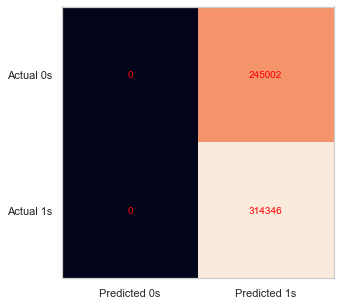

In [62]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    245002
           1       0.56      1.00      0.72    314346

    accuracy                           0.56    559348
   macro avg       0.28      0.50      0.36    559348
weighted avg       0.32      0.56      0.40    559348



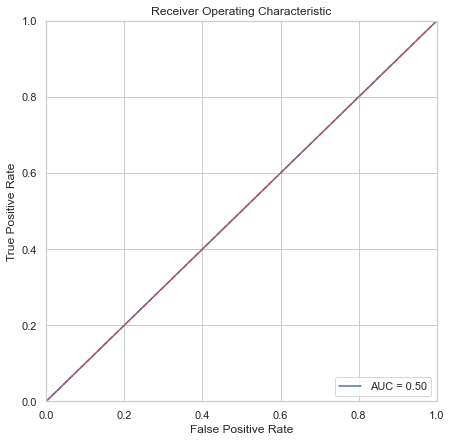

In [63]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), predictions)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Logistic Regression

In [64]:
# Create logistic regression model

# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    logmodel = LogisticRegression()
    logmodel.fit(X_train[i],y_train[i])
    fold_predictions = logmodel.predict(X_test[i])
    fold_probabilities = logmodel.predict_proba(X_test[i])[:,1]
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
accuracies

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

[0.6443192991865558,
 0.6476267095736122,
 0.6452310717797444,
 0.6472870295879145,
 0.6442656655046035,
 0.6468937159202646,
 0.6453919728256011,
 0.6446589791722535,
 0.6477455572639181,
 0.6485500768763185]

In [65]:
# Get model coefficients (for the last fold)
coefficients = logmodel.coef_[0]
cat_coefs = pd.DataFrame({'category': categories, 'coefficient': coefficients})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cat_coefs)

                   category  coefficient
0               C_YEAR_2012     0.021335
1               C_YEAR_2013     0.032284
2               C_YEAR_2014     0.054184
3                  C_MNTH_2     0.069596
4                  C_MNTH_3     0.143230
5                  C_MNTH_4     0.129448
6                  C_MNTH_5     0.101703
7                  C_MNTH_6     0.068699
8                  C_MNTH_7     0.062810
9                  C_MNTH_8     0.068740
10                 C_MNTH_9     0.089814
11                C_MNTH_10     0.082712
12                C_MNTH_11     0.124275
13                C_MNTH_12     0.024662
14                 C_WDAY_2    -0.016488
15                 C_WDAY_3    -0.030144
16                 C_WDAY_4    -0.056063
17                 C_WDAY_5    -0.058766
18                 C_WDAY_6    -0.111481
19                 C_WDAY_7    -0.089637
20        C_HOUR_[3.0, 6.0)     0.209029
21        C_HOUR_[6.0, 9.0)    -0.339213
22       C_HOUR_[9.0, 12.0)    -0.400955
23      C_HOUR_[

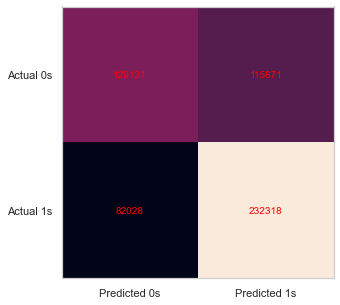

In [66]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.53      0.57    245002
           1       0.67      0.74      0.70    314346

    accuracy                           0.65    559348
   macro avg       0.64      0.63      0.63    559348
weighted avg       0.64      0.65      0.64    559348



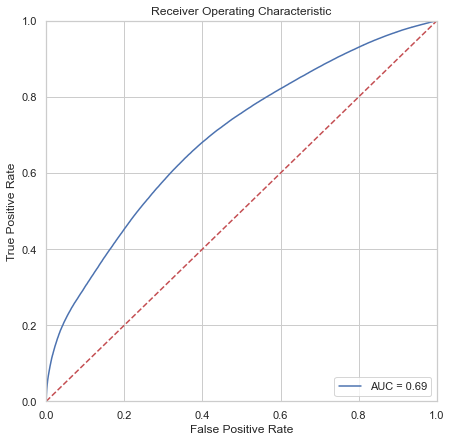

In [67]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Neural Network

In [68]:
# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    
    # Split training set into training and validation
    X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train[i], 
                                                        y_train[i], test_size=0.10, 
                                                        random_state=201)

    # Create the neural network
    model_nn = models.Sequential()
    model_nn.add(layers.Dense(99, input_dim=99, activation='relu'))
    model_nn.add(layers.Dense(20, activation='relu'))
    model_nn.add(layers.Dense(1, activation='sigmoid'))
    model_nn.summary()

    es = EarlyStopping(monitor='accuracy')
    cc = ModelCheckpoint('model.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='min')

    model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model_nn.fit(X_train_nn, y_train_nn, epochs=15, 
                          validation_data=(X_val, y_val),
                          callbacks=[es, cc])

    # Halve the learning rate and run again
    model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model_nn.fit(X_train_nn, y_train_nn, epochs=15, 
                          validation_data=(X_val, y_val),
                          callbacks=[es, cc])

    # Halve the learning rate again and run again
    model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model_nn.fit(X_train_nn, y_train_nn, epochs=15, 
                          validation_data=(X_val, y_val),
                          callbacks=[es, cc])

    # Get prediction probabilities
    fold_probabilities = model_nn.predict(X_test[i])

    # Get predictions in 1s and 0s
    fold_predictions = np.array(fold_probabilities, copy=True) 
    fold_predictions[fold_predictions >= 0.5] = 1
    fold_predictions[fold_predictions < 0.5] = 0
    
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
    
print(accuracies)  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 99)                9900      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 11,921
Trainable params: 11,921
Non-trainable params: 0
_________________________________________________________________
Train on 453071 samples, validate on 50342 samples
Epoch 1/15
452576/453071 [============================>.] - ETA: 0s - loss: 0.6130 - accuracy: 0.6547
Epoch 00001: accuracy improved from inf to 0.65464, saving model to model.h5
453071/453071 [==============================] - 34s 75us/sample - loss: 0.6131 - accuracy: 0.6546 - val_loss: 0.6057 - val_accuracy: 0.6597
Epoch 2/15


452832/453071 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.6787 ETA: 0s - loss: 0.5817 - ac
Epoch 00005: accuracy did not improve from 0.65464
453071/453071 [==============================] - 28s 62us/sample - loss: 0.5816 - accuracy: 0.6787 - val_loss: 0.6101 - val_accuracy: 0.6617
Epoch 6/15
453056/453071 [============================>.] - ETA: 0s - loss: 0.5814 - accuracy: 0.6784
Epoch 00006: accuracy did not improve from 0.65464
453071/453071 [==============================] - 29s 63us/sample - loss: 0.5814 - accuracy: 0.6784 - val_loss: 0.6104 - val_accuracy: 0.6612
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 99)                9900      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2000      
___________________________________________

452448/453071 [============================>.] - ETA: 0s - loss: 0.6142 - accuracy: 0.6533
Epoch 00001: accuracy improved from inf to 0.65328, saving model to model.h5
453071/453071 [==============================] - 28s 62us/sample - loss: 0.6142 - accuracy: 0.6533 - val_loss: 0.6061 - val_accuracy: 0.6620
Epoch 2/15
452800/453071 [============================>.] - ETA: 0s - loss: 0.6047 - accuracy: 0.6613
Epoch 00002: accuracy did not improve from 0.65328
453071/453071 [==============================] - 28s 61us/sample - loss: 0.6048 - accuracy: 0.6613 - val_loss: 0.6047 - val_accuracy: 0.6622
Epoch 3/15
452896/453071 [============================>.] - ETA: 0s - loss: 0.6024 - accuracy: 0.6632
Epoch 00003: accuracy did not improve from 0.65328
453071/453071 [==============================] - 28s 61us/sample - loss: 0.6024 - accuracy: 0.6632 - val_loss: 0.6038 - val_accuracy: 0.6628
Epoch 4/15
452288/453071 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.6649
E

452416/453071 [============================>.] - ETA: 0s - loss: 0.6005 - accuracy: 0.6648
Epoch 00004: accuracy did not improve from 0.65426
453071/453071 [==============================] - 28s 63us/sample - loss: 0.6005 - accuracy: 0.6648 - val_loss: 0.6032 - val_accuracy: 0.6646
Epoch 5/15
452512/453071 [============================>.] - ETA: 0s - loss: 0.5990 - accuracy: 0.6658
Epoch 00005: accuracy did not improve from 0.65426
453071/453071 [==============================] - 31s 69us/sample - loss: 0.5990 - accuracy: 0.6658 - val_loss: 0.6035 - val_accuracy: 0.6623
Epoch 6/15
452576/453071 [============================>.] - ETA: 0s - loss: 0.5977 - accuracy: 0.6667
Epoch 00006: accuracy did not improve from 0.65426
453071/453071 [==============================] - 30s 66us/sample - loss: 0.5976 - accuracy: 0.6668 - val_loss: 0.6026 - val_accuracy: 0.6642
Epoch 7/15
452384/453071 [============================>.] - ETA: 0s - loss: 0.5964 - accuracy: 0.6675
Epoch 00007: accuracy did n

452320/453071 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.6643
Epoch 00003: accuracy did not improve from 0.65459
453071/453071 [==============================] - 30s 65us/sample - loss: 0.6016 - accuracy: 0.6642 - val_loss: 0.6056 - val_accuracy: 0.6597
Epoch 4/15
452960/453071 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.6655
Epoch 00004: accuracy did not improve from 0.65459
453071/453071 [==============================] - 29s 64us/sample - loss: 0.5998 - accuracy: 0.6655 - val_loss: 0.6081 - val_accuracy: 0.6585
Epoch 5/15
452288/453071 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.6662
Epoch 00005: accuracy did not improve from 0.65459
453071/453071 [==============================] - 29s 63us/sample - loss: 0.5985 - accuracy: 0.6663 - val_loss: 0.6077 - val_accuracy: 0.6577
Epoch 6/15
452416/453071 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.6674
Epoch 00006: accuracy did n

452736/453071 [============================>.] - ETA: 0s - loss: 0.6135 - accuracy: 0.6531
Epoch 00001: accuracy improved from inf to 0.65309, saving model to model.h5
453071/453071 [==============================] - 31s 68us/sample - loss: 0.6135 - accuracy: 0.6531 - val_loss: 0.6101 - val_accuracy: 0.6600
Epoch 2/15
452672/453071 [============================>.] - ETA: 0s - loss: 0.6045 - accuracy: 0.6618
Epoch 00002: accuracy did not improve from 0.65309
453071/453071 [==============================] - 28s 63us/sample - loss: 0.6045 - accuracy: 0.6618 - val_loss: 0.6065 - val_accuracy: 0.6618
Epoch 3/15
452800/453071 [============================>.] - ETA: 0s - loss: 0.6020 - accuracy: 0.6636 ETA: 0s - loss: 0.6019 - accura
Epoch 00003: accuracy did not improve from 0.65309
453071/453071 [==============================] - 28s 62us/sample - loss: 0.6020 - accuracy: 0.6635 - val_loss: 0.6063 - val_accuracy: 0.6607
Epoch 4/15
452576/453071 [============================>.] - ETA: 0s - l

452640/453071 [============================>.] - ETA: 0s - loss: 0.6045 - accuracy: 0.6622
Epoch 00002: accuracy did not improve from 0.65363
453071/453071 [==============================] - 28s 61us/sample - loss: 0.6045 - accuracy: 0.6622 - val_loss: 0.6042 - val_accuracy: 0.6621
Epoch 3/15
452256/453071 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.6639 ETA: 0s - loss: 0.6019 - accuracy: 0.66
Epoch 00003: accuracy did not improve from 0.65363
453071/453071 [==============================] - 29s 65us/sample - loss: 0.6019 - accuracy: 0.6639 - val_loss: 0.6043 - val_accuracy: 0.6621
Epoch 4/15
452928/453071 [============================>.] - ETA: 0s - loss: 0.6002 - accuracy: 0.6651
Epoch 00004: accuracy did not improve from 0.65363
453071/453071 [==============================] - 29s 64us/sample - loss: 0.6002 - accuracy: 0.6651 - val_loss: 0.6030 - val_accuracy: 0.6632
Epoch 5/15
452832/453071 [============================>.] - ETA: 0s - loss: 0.5987 - accu

452704/453071 [============================>.] - ETA: 0s - loss: 0.5803 - accuracy: 0.6787
Epoch 00002: accuracy did not improve from 0.65363
453071/453071 [==============================] - 26s 57us/sample - loss: 0.5803 - accuracy: 0.6787 - val_loss: 0.6118 - val_accuracy: 0.6609
Epoch 3/15
452672/453071 [============================>.] - ETA: 0s - loss: 0.5800 - accuracy: 0.6788
Epoch 00003: accuracy did not improve from 0.65363
453071/453071 [==============================] - 26s 57us/sample - loss: 0.5801 - accuracy: 0.6788 - val_loss: 0.6123 - val_accuracy: 0.6618
Epoch 4/15
452224/453071 [============================>.] - ETA: 0s - loss: 0.5799 - accuracy: 0.6793
Epoch 00004: accuracy did not improve from 0.65363
453071/453071 [==============================] - 26s 58us/sample - loss: 0.5799 - accuracy: 0.6793 - val_loss: 0.6127 - val_accuracy: 0.6603
Epoch 5/15
452672/453071 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.6792
Epoch 00005: accuracy did n

Epoch 7/15
452288/453071 [============================>.] - ETA: 0s - loss: 0.5838 - accuracy: 0.6773
Epoch 00007: accuracy did not improve from 0.65418
453071/453071 [==============================] - 25s 56us/sample - loss: 0.5837 - accuracy: 0.6774 - val_loss: 0.6125 - val_accuracy: 0.6585
Train on 453071 samples, validate on 50342 samples
Epoch 1/15
452512/453071 [============================>.] - ETA: 0s - loss: 0.5815 - accuracy: 0.6790
Epoch 00001: accuracy did not improve from 0.65418
453071/453071 [==============================] - 30s 66us/sample - loss: 0.5815 - accuracy: 0.6790 - val_loss: 0.6129 - val_accuracy: 0.6591
Epoch 2/15
452768/453071 [============================>.] - ETA: 0s - loss: 0.5811 - accuracy: 0.6794
Epoch 00002: accuracy did not improve from 0.65418
453071/453071 [==============================] - 26s 56us/sample - loss: 0.5811 - accuracy: 0.6794 - val_loss: 0.6129 - val_accuracy: 0.6589
Epoch 3/15
452832/453071 [============================>.] - ETA: 0s

452608/453072 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.6780
Epoch 00002: accuracy did not improve from 0.65396
453072/453072 [==============================] - 29s 63us/sample - loss: 0.5832 - accuracy: 0.6780 - val_loss: 0.6111 - val_accuracy: 0.6605
Epoch 3/15
453056/453072 [============================>.] - ETA: 0s - loss: 0.5829 - accuracy: 0.6780
Epoch 00003: accuracy did not improve from 0.65396
453072/453072 [==============================] - 29s 63us/sample - loss: 0.5829 - accuracy: 0.6780 - val_loss: 0.6122 - val_accuracy: 0.6588
Epoch 4/15
453056/453072 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.6782
Epoch 00004: accuracy did not improve from 0.65396
453072/453072 [==============================] - 28s 63us/sample - loss: 0.5826 - accuracy: 0.6782 - val_loss: 0.6125 - val_accuracy: 0.6594
Epoch 5/15
452448/453072 [============================>.] - ETA: 0s - loss: 0.5823 - accuracy: 0.6785
Epoch 00005: accuracy did n

Train on 453072 samples, validate on 50342 samples
Epoch 1/15
452576/453072 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.6770
Epoch 00001: accuracy did not improve from 0.65344
453072/453072 [==============================] - 33s 73us/sample - loss: 0.5835 - accuracy: 0.6770 - val_loss: 0.6104 - val_accuracy: 0.6590
Epoch 2/15
452096/453072 [============================>.] - ETA: 0s - loss: 0.5831 - accuracy: 0.6769
Epoch 00002: accuracy did not improve from 0.65344
453072/453072 [==============================] - 30s 67us/sample - loss: 0.5831 - accuracy: 0.6769 - val_loss: 0.6106 - val_accuracy: 0.6583
[0.6584428354339859, 0.6620362921247877, 0.6623759721104854, 0.6582283007061768, 0.657459551264861, 0.6611066416376151, 0.6586931259497631, 0.6577634754625905, 0.658472485429256, 0.6620481281510352]


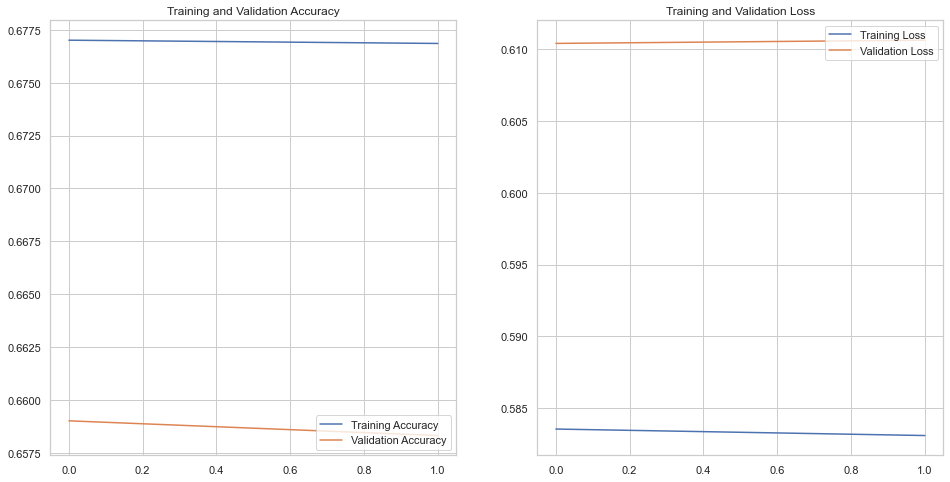

In [69]:
# Plot accuracy and loss (for the last fold)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

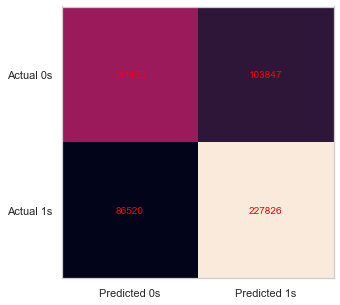

In [70]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.58      0.60    245002
           1       0.69      0.72      0.71    314346

    accuracy                           0.66    559348
   macro avg       0.65      0.65      0.65    559348
weighted avg       0.66      0.66      0.66    559348



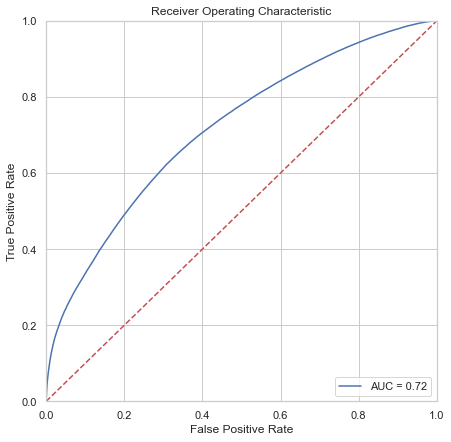

In [71]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test), predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Decision Tree

In [73]:
# Build the decision tree
# We want to limit the depth to avoid overfitting, so we need to find optimal max_depth
# Train our model using a subset of the training data (like in nerual network above) and use part of it for validation
# Use validation set to find optimal paramaters (i.e. max_depth) and then evaluate model with the testing set

# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    
    # Split training set into training and validation
    X_train_dt, X_val, y_train_dt, y_val = train_test_split(X_train[i], y_train[i], test_size=0.10, random_state=201)

    # Find the best max_depth based on the validation set
    depth_accuracies = []
    for j in range(1,21):
        dt = DecisionTreeClassifier(max_depth=j, random_state=301)
        dt.fit(X_train_dt, y_train_dt)
        depth_predictions = dt.predict(X_val)
        acc = accuracy_score(y_val, depth_predictions)
        depth_accuracies.append(acc)
    optimal_depth = np.argmax(depth_accuracies)
    print(max(depth_accuracies))
    print(optimal_depth)
    
    # Now use optimal max_depth to create final model
    dt = DecisionTreeClassifier(max_depth=optimal_depth)
    dt.fit(X_train_dt, y_train_dt)

    # Get predictions for test set
    fold_predictions = dt.predict(X_test[i])
    fold_probabilities = dt.predict_proba(X_test[i])[:,1]
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
accuracies

0.658356839219737
10
0.6563704262842159
11
0.6585952087719995
11
0.6581383337968297
11
0.6565889317071233
12
0.6559532795677565
12
0.6556950458861388
10
0.6564498828016369
11
0.6575821381748838
10
0.6578801001152119
11


[0.6535264145883615,
 0.6569053365513543,
 0.6555823723965317,
 0.657459551264861,
 0.6561008313220703,
 0.658871904889604,
 0.6561902207919907,
 0.6549208903191204,
 0.6552544069796546,
 0.6578109915257268]

[Text(502.20000000000005, 489.24, 'P_SEX_M <= 0.5\ngini = 0.492\nsamples = 453072\nvalue = [198441, 254631]\nclass = 1'),
 Text(251.10000000000002, 380.52000000000004, 'P_PSN_[21.0, 31.0) <= 0.5\ngini = 0.459\nsamples = 214983\nvalue = [76699, 138284]\nclass = 1'),
 Text(125.55000000000001, 271.8, 'C_RSUR_5 <= 0.5\ngini = 0.443\nsamples = 187156\nvalue = [62095, 125061]\nclass = 1'),
 Text(62.775000000000006, 163.08000000000004, 'C_RCFG_2 <= 0.5\ngini = 0.451\nsamples = 174519\nvalue = [59859, 114660]\nclass = 1'),
 Text(31.387500000000003, 54.360000000000014, '\n  (...)  \n'),
 Text(94.16250000000001, 54.360000000000014, '\n  (...)  \n'),
 Text(188.32500000000002, 163.08000000000004, 'C_CONF_[21.0, 31.0) <= 0.5\ngini = 0.291\nsamples = 12637\nvalue = [2236, 10401]\nclass = 1'),
 Text(156.9375, 54.360000000000014, '\n  (...)  \n'),
 Text(219.71250000000003, 54.360000000000014, '\n  (...)  \n'),
 Text(376.65000000000003, 271.8, 'P_SAFE_2 <= 0.5\ngini = 0.499\nsamples = 27827\nvalue = [1

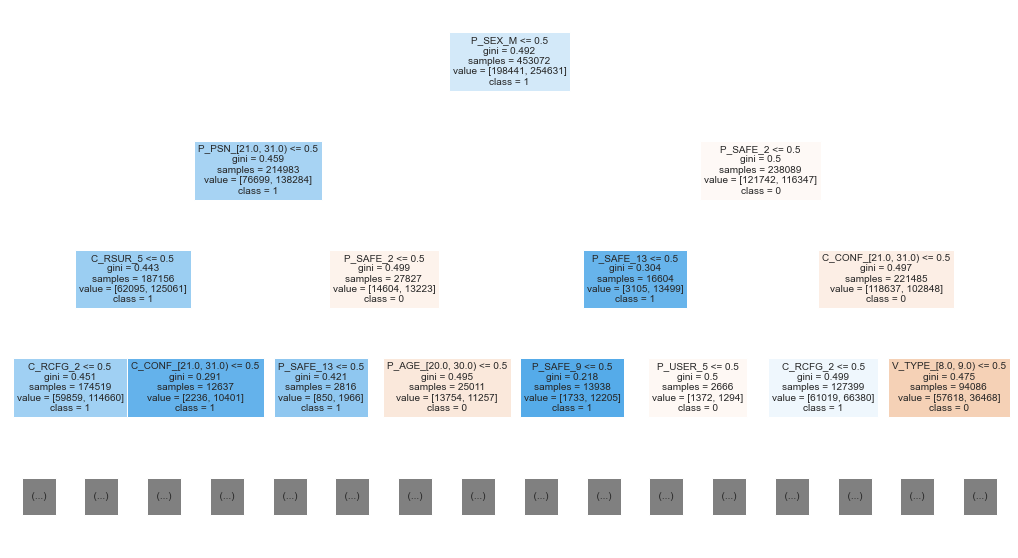

In [74]:
# Visualize the top of the decision tree (for the last fold)
fig, ax = plt.subplots(figsize=(18, 10))
tree.plot_tree(dt,
               feature_names = categories, 
               class_names=['0', '1'],
               max_depth = 3, 
               fontsize=10, 
               filled = True)

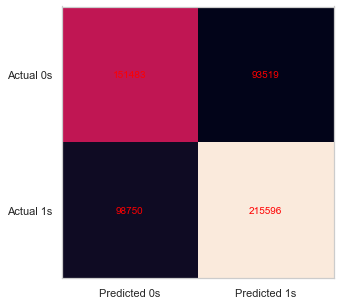

In [75]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.62      0.61    245002
           1       0.70      0.69      0.69    314346

    accuracy                           0.66    559348
   macro avg       0.65      0.65      0.65    559348
weighted avg       0.66      0.66      0.66    559348



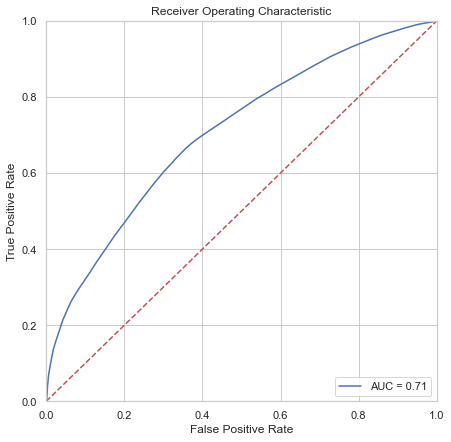

In [76]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Naive Bayes

In [77]:
# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    nb = naive_bayes.CategoricalNB()
    model_nb = nb.fit(X_train[i], y_train[i])
    fold_predictions = model_nb.predict(X_test[i])
    fold_probabilities = model_nb.predict_proba(X_test[i])[:,1]
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
accuracies

[0.6239563779386789,
 0.6239742558326629,
 0.620345043353893,
 0.6204165549298293,
 0.6201126307320998,
 0.6229730937695539,
 0.6198265844283544,
 0.6223473674801109,
 0.6232881610469482,
 0.6256480852433225]

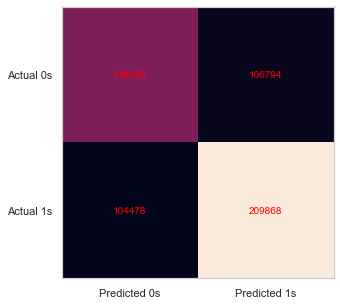

In [78]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.56      0.57    245002
           1       0.66      0.67      0.67    314346

    accuracy                           0.62    559348
   macro avg       0.62      0.62      0.62    559348
weighted avg       0.62      0.62      0.62    559348



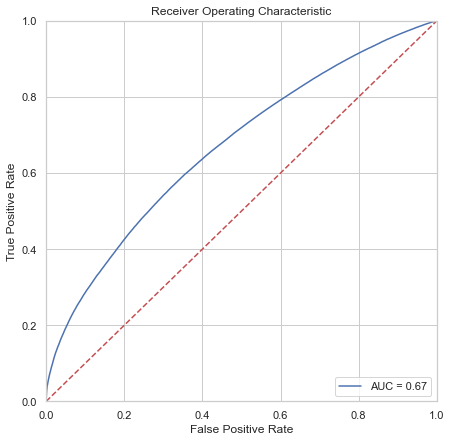

In [79]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()